# III. RUL Regression

## Objective

Predict **Remaining Useful Life (RUL)** — expressed as a percentage of total service life — for each simulated landing event using two tree-based ensemble regression models:

| Model | Role |
|---|---|
| Random Forest Regressor | Bagged ensemble of regression trees |
| XGBoost Regressor | Sequential gradient-boosted regression trees |

RUL regression is performed exclusively on the **primary 1,500-record dataset**, which is the only dataset that provides a valid, fully-populated RUL target variable. AEROTWIN does not contain a usable RUL column and is not used here.

## Evaluation Metrics

| Metric | Interpretation |
|---|---|
| MAE | Average error in percentage-point RUL; directly interpretable for maintenance planning |
| RMSE | Penalises large errors more heavily; operationally relevant since a large overestimate could leave a degraded component in service |

## Setup

Import all required libraries. `RANDOM_STATE = 42` ensures every stochastic step is fully reproducible.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, train_test_split
from xgboost import XGBRegressor

sns.set_theme(style="whitegrid", context="notebook")
RANDOM_STATE = 42

CLASS_NAMES = {
    0: "Normal Operation",
    1: "N2 Gas Leak",
    2: "Worn Seal",
    3: "Early Structural Degradation",
}

## Data Loading and Feature Engineering

Load the primary dataset and compute the two physics-derived features. `RUL` is the regression target; `Fault_Code` is retained solely for stratification and per-class error analysis — it is not an input to the regression models.

In [2]:
DATA_PATH = Path("../data/raw/LandingGear_Balanced_Dataset.csv")
df = pd.read_csv(DATA_PATH)

df["zeta"]    = df["B_Damping"] / (2 * np.sqrt(df["K_Stiffness"] * df["Mass"]))
df["omega_n"] = np.sqrt(df["K_Stiffness"] / df["Mass"])

print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"RUL range : {df['RUL'].min():.2f} – {df['RUL'].max():.2f} %")
print(f"RUL mean  : {df['RUL'].mean():.2f} %   std: {df['RUL'].std():.2f} %")
df[["RUL"]].describe().T

Dataset: 1,500 rows, 11 columns
RUL range : 0.00 – 99.93 %
RUL mean  : 62.10 %   std: 29.63 %


,count,mean,std,min,25%,50%,75%,max
RUL,1500.0,62.10263,29.634244,0.0,37.4,72.0625,87.653833,99.930846


## Feature Selection and Train-Test Split

The feature matrix **X** uses the full 8-feature set (the same inputs as the classification task). `RUL` is the continuous target **y**. The dataset is split **80 / 20** with stratification on `Fault_Code` — ensuring each fault class is proportionally represented in both partitions and enabling per-class error breakdowns on the test set. No feature scaling is applied; tree-based regressors are scale-invariant.

In [3]:
FEATURE_COLS = [
    "Max_Deflection", "Max_Velocity", "Settling_Time",
    "Mass", "K_Stiffness", "B_Damping",
    "zeta", "omega_n",
]
TARGET = "RUL"

X  = df[FEATURE_COLS].values
y  = df[TARGET].values
fc = df["Fault_Code"].values  # retained for stratification and per-class error analysis

X_train, X_test, y_train, y_test, fc_train, fc_test = train_test_split(
    X, y, fc, test_size=0.20, random_state=RANDOM_STATE, stratify=fc
)

print(f"Train : {len(X_train):,} samples")
print(f"Test  : {len(X_test):,} samples")

Train : 1,200 samples
Test  : 300 samples


## Helper Function

`evaluate_model` computes MAE and RMSE on the full test set and separately for each fault class. Per-class breakdowns reveal whether prediction difficulty varies with the health state of the component.

In [4]:
def evaluate_model(name, y_true, y_pred, fault_codes):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print("=" * 60)
    print(f"  {name}")
    print("=" * 60)
    print(f"  Overall  MAE  = {mae:.4f} pp")
    print(f"  Overall  RMSE = {rmse:.4f} pp")
    print()
    for fc in sorted(set(fault_codes)):
        mask = fault_codes == fc
        m = mean_absolute_error(y_true[mask], y_pred[mask])
        r = root_mean_squared_error(y_true[mask], y_pred[mask])
        print(f"  {CLASS_NAMES[fc]:<32}  MAE={m:.4f}  RMSE={r:.4f}")
    print()
    return {"Model": name, "MAE": round(mae, 4), "RMSE": round(rmse, 4)}

results = []

## Random Forest Regressor

A Random Forest of 300 regression trees, each trained on a bootstrap sample with a random feature subset (`max_features=sqrt`) at every split. Predictions are the mean of all tree outputs, reducing variance compared to a single tree.

In [5]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_features="sqrt",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results.append(evaluate_model("Random Forest", y_test, y_pred_rf, fc_test))

  Random Forest
  Overall  MAE  = 1.1535 pp
  Overall  RMSE = 2.2928 pp

  Normal Operation                  MAE=3.8375  RMSE=4.5765
  N2 Gas Leak                       MAE=0.3952  RMSE=0.6748
  Worn Seal                         MAE=0.6295  RMSE=1.6145
  Early Structural Degradation      MAE=0.3334  RMSE=0.5960



## XGBoost Regressor

XGBoost builds regression trees **sequentially**, each correcting the residual errors of the ensemble so far. The same hyperparameters as in the classification task are used to support a consistent model comparison.

| Parameter | Value | Reason |
|---|---|---|
| n_estimators | 300 | Boosting rounds |
| learning_rate | 0.1 | Shrinkage per tree to reduce overfitting |
| max_depth | 6 | Per-tree complexity limit |
| subsample | 0.8 | Row subsampling — stochastic regularisation |
| colsample_bytree | 0.8 | Column subsampling per tree |

In [6]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

results.append(evaluate_model("XGBoost", y_test, y_pred_xgb, fc_test))

  XGBoost
  Overall  MAE  = 1.1601 pp
  Overall  RMSE = 2.3561 pp

  Normal Operation                  MAE=4.2067  RMSE=4.9275
  N2 Gas Leak                       MAE=0.3192  RMSE=0.4787
  Worn Seal                         MAE=0.5605  RMSE=1.3434
  Early Structural Degradation      MAE=0.1913  RMSE=0.3593



## Metric Summary

Collect MAE and RMSE for both models and display a grouped bar chart for side-by-side comparison.

,MAE,RMSE
Model,,
Random Forest,1.1535,2.2928
XGBoost,1.1601,2.3561


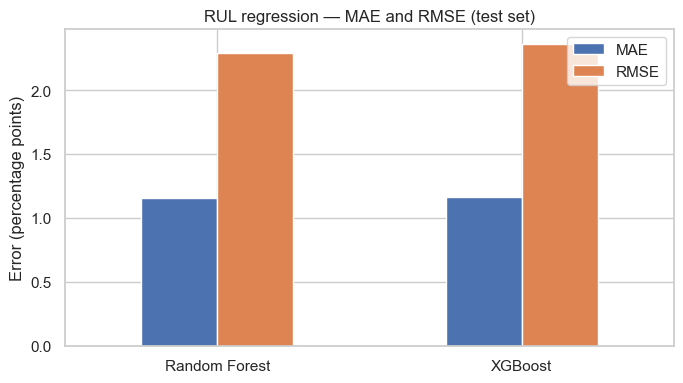

In [7]:
summary = pd.DataFrame(results).set_index("Model")
display(summary)

ax = summary.plot(kind="bar", figsize=(7, 4), width=0.5)
ax.set_title("RUL regression — MAE and RMSE (test set)")
ax.set_ylabel("Error (percentage points)")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Cross-Validation Stability Check

**5-fold cross-validation** using standard `KFold` with shuffling — `StratifiedKFold` is not applicable to a continuous regression target. CV is run on the training set only, providing mean ± std for both MAE and RMSE across folds. A low standard deviation confirms the hold-out result is not an artefact of the particular split.

Random Forest              MAE = 1.2915 +/- 0.0603   RMSE = 2.4810 +/- 0.0909
XGBoost                    MAE = 1.2200 +/- 0.0545   RMSE = 2.4931 +/- 0.0862


C:\Users\Zsolti\AppData\Local\Temp\ipykernel_21208\1871990303.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(cv_mae.values(),  labels=cv_mae.keys(),  patch_artist=True)
C:\Users\Zsolti\AppData\Local\Temp\ipykernel_21208\1871990303.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(cv_rmse.values(), labels=cv_rmse.keys(), patch_artist=True)


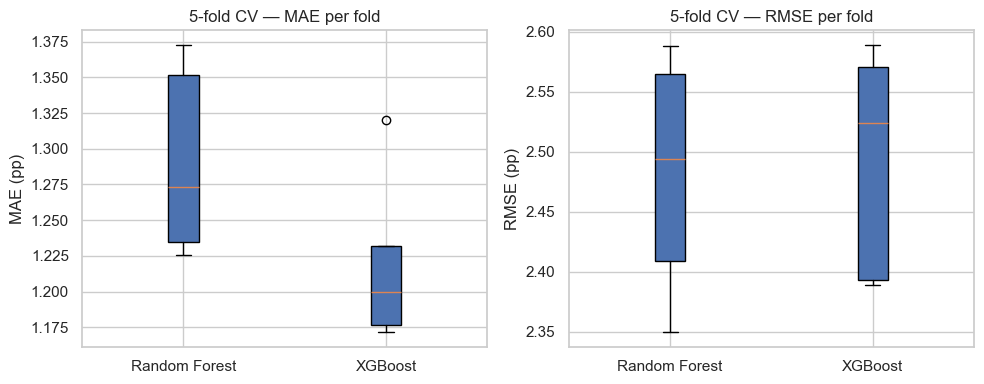

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_mae, cv_rmse = {}, {}
for name, model in [("Random Forest", rf), ("XGBoost", xgb)]:
    res = cross_validate(
        model, X_train, y_train, cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        n_jobs=-1,
    )
    mae_folds  = -res["test_neg_mean_absolute_error"]
    rmse_folds = -res["test_neg_root_mean_squared_error"]
    cv_mae[name]  = mae_folds
    cv_rmse[name] = rmse_folds
    print(f"{name:<25}  MAE = {mae_folds.mean():.4f} +/- {mae_folds.std():.4f}"
          f"   RMSE = {rmse_folds.mean():.4f} +/- {rmse_folds.std():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].boxplot(cv_mae.values(),  labels=cv_mae.keys(),  patch_artist=True)
axes[0].set_title("5-fold CV — MAE per fold")
axes[0].set_ylabel("MAE (pp)")
axes[1].boxplot(cv_rmse.values(), labels=cv_rmse.keys(), patch_artist=True)
axes[1].set_title("5-fold CV — RMSE per fold")
axes[1].set_ylabel("RMSE (pp)")
for ax in axes:
    ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

## Residual Analysis

Two complementary views of prediction error:

- **Predicted vs Actual** — points on the diagonal indicate perfect predictions;   deviations reveal systematic under- or over-estimation across the RUL range,   coloured by fault class to expose class-specific patterns.
- **Residual distribution** — histogram of (y_pred − y_true);   a distribution centred near zero with small spread confirms unbiased predictions.

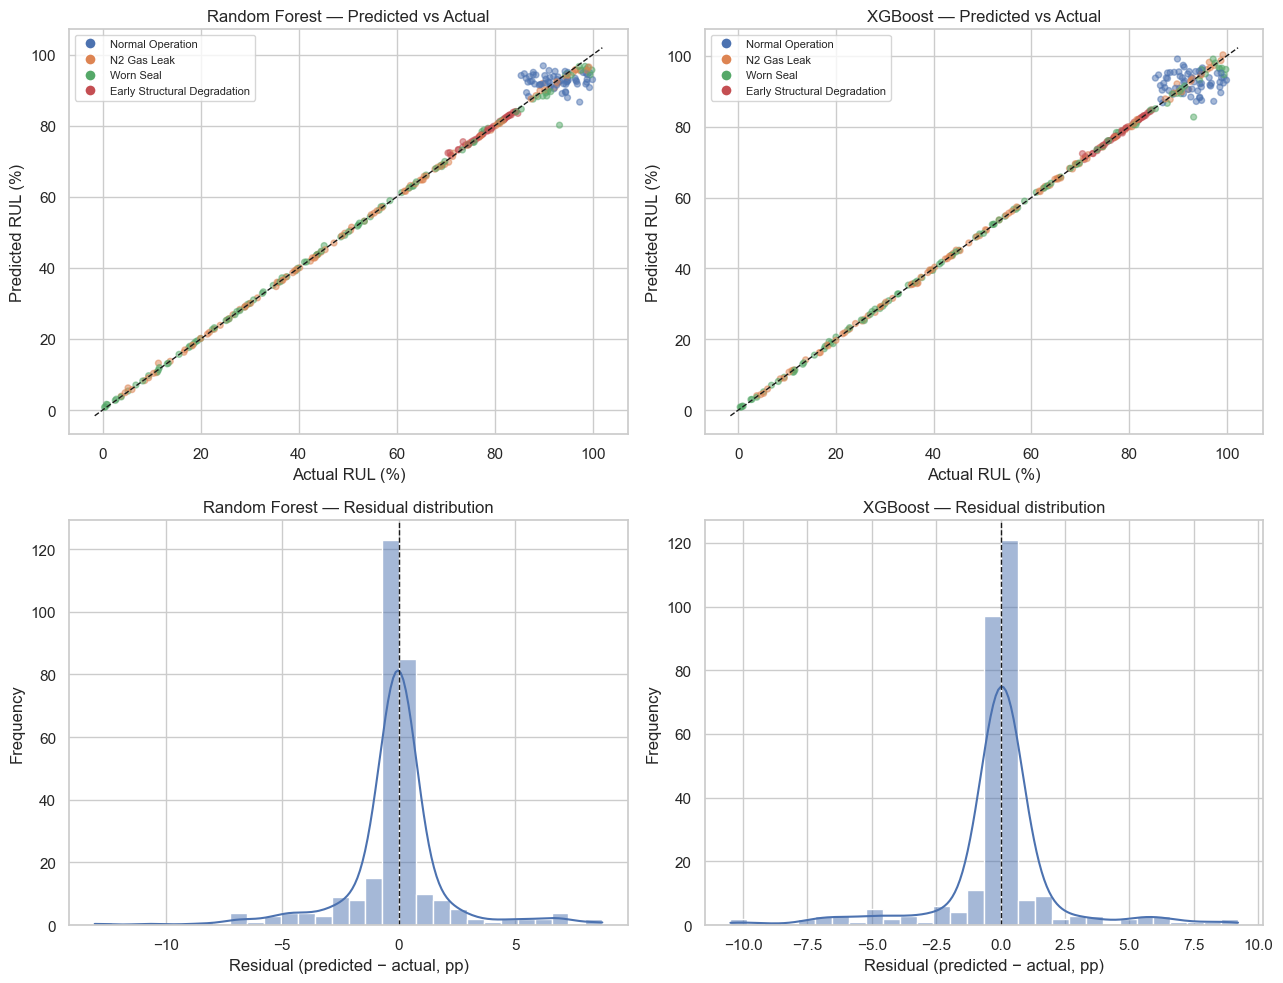

In [9]:
palette = {0: "#4c72b0", 1: "#dd8452", 2: "#55a868", 3: "#c44e52"}
colors  = [palette[fc] for fc in fc_test]

fig, axes = plt.subplots(2, 2, figsize=(13, 10))

for col, (name, y_pred) in enumerate([("Random Forest", y_pred_rf), ("XGBoost", y_pred_xgb)]):
    # Predicted vs actual
    ax = axes[0, col]
    ax.scatter(y_test, y_pred, c=colors, alpha=0.5, s=18)
    lims = [min(y_test.min(), y_pred.min()) - 2, max(y_test.max(), y_pred.max()) + 2]
    ax.plot(lims, lims, "k--", lw=1)
    ax.set_xlabel("Actual RUL (%)")
    ax.set_ylabel("Predicted RUL (%)")
    ax.set_title(f"{name} — Predicted vs Actual")
    handles = [plt.Line2D([0], [0], marker="o", color="w",
               markerfacecolor=palette[fc], markersize=8, label=CLASS_NAMES[fc])
               for fc in sorted(palette)]
    ax.legend(handles=handles, fontsize=8, loc="upper left")

    # Residual distribution
    ax2 = axes[1, col]
    residuals = y_pred - y_test
    sns.histplot(residuals, bins=30, kde=True, ax=ax2, color="#4c72b0")
    ax2.axvline(0, color="k", linestyle="--", lw=1)
    ax2.set_xlabel("Residual (predicted − actual, pp)")
    ax2.set_ylabel("Frequency")
    ax2.set_title(f"{name} — Residual distribution")

plt.tight_layout()
plt.show()

## Feature Importance

Mean decrease in impurity across all regression tree splits. Comparing these rankings with those from the classification task (notebook 02) reveals whether the same features drive both fault identification and RUL estimation, or whether each task relies on a different aspect of the physics-informed feature set.

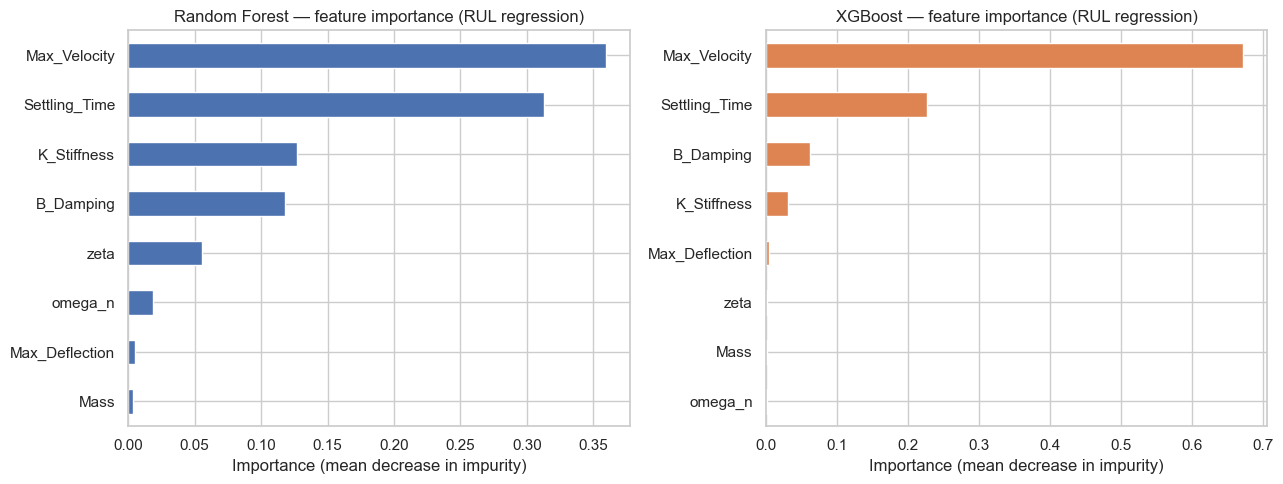

In [10]:
fi_rf  = pd.Series(rf.feature_importances_,  index=FEATURE_COLS).sort_values()
fi_xgb = pd.Series(xgb.feature_importances_, index=FEATURE_COLS).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fi_rf.plot(kind="barh",  ax=axes[0], color="#4c72b0",
           title="Random Forest — feature importance (RUL regression)")
fi_xgb.plot(kind="barh", ax=axes[1], color="#dd8452",
            title="XGBoost — feature importance (RUL regression)")
for ax in axes:
    ax.set_xlabel("Importance (mean decrease in impurity)")
plt.tight_layout()
plt.show()

## Key Findings

### Overall test-set performance

| Model | MAE (pp) | RMSE (pp) |
|---|---|---|
| **Random Forest** | **1.1535** | **2.2928** |
| XGBoost | 1.1601 | 2.3561 |

Both models achieve nearly identical accuracy. **Random Forest is marginally the better regressor** on the hold-out test set (MAE 1.15 pp vs 1.16 pp; RMSE 2.29 pp vs 2.36 pp). An MAE of ~1.15 percentage points means predictions are, on average, within 1.15 % of total service life — operationally acceptable for maintenance planning.

### Per-class error breakdown (test set)

| Fault Class | RF MAE | RF RMSE | XGB MAE | XGB RMSE |
|---|---|---|---|---|
| Normal Operation | 3.8375 | 4.5765 | 4.2067 | 4.9275 |
| N2 Gas Leak | 0.3952 | 0.6748 | 0.3192 | 0.4787 |
| Worn Seal | 0.6295 | 1.6145 | 0.5605 | 1.3434 |
| Early Structural Degradation | 0.3334 | 0.5960 | 0.1913 | 0.3593 |

**Normal Operation is by far the hardest class to predict** (RF MAE 3.84 pp, XGB 4.21 pp). The healthy regime spans the full RUL range with no fault-specific signature to anchor the prediction. Fault classes achieve much lower errors (MAE < 0.7 pp for RF), as each injected fault condition imposes a distinctive degradation trajectory on RUL.

### Cross-validation stability (5-fold KFold, training set)

| Model | Mean MAE | Std | Mean RMSE | Std |
|---|---|---|---|---|
| Random Forest | 1.2915 | ±0.0603 | 2.4810 | ±0.0909 |
| XGBoost | 1.2200 | ±0.0545 | 2.4931 | ±0.0862 |

XGBoost shows a lower and more stable CV MAE (1.22 vs 1.29 pp). Both models generalise consistently — standard deviations are small relative to the mean, confirming the test-set result is representative of the models' true predictive ability.

### Feature importance — contrast with the classification task

The dominant features **invert** between the classification and regression tasks:

| Feature | RF (regression) | RF (classification) |
|---|---|---|
| Max_Velocity | 0.3594 | 0.1315 |
| Settling_Time | 0.3126 | 0.1815 |
| K_Stiffness | 0.1267 | 0.2855 |
| B_Damping | 0.1179 | 0.2889 |

For **classification**, `B_Damping` and `K_Stiffness` dominate because fault classes are defined by injecting changes to exactly those parameters. For **RUL regression**, `Max_Velocity` and `Settling_Time` — the dynamic sensor signals — drive predictions because they capture the severity of each landing impact and the rate of energy dissipation, which determine how quickly service life is consumed. This contrast validates the complementary value of both sensor-derived and physics-parameterised features in the dataset, and demonstrates that the two tasks are supported by different aspects of the physics-informed feature space.